In [16]:
from obs_models import *
from generate_data import *
from utils import *

%matplotlib inline

In [7]:
N, D = 1000, 10
data = make_normal_data(N,D)

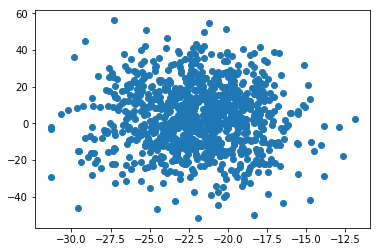

In [8]:
pyplot.scatter(*data[:,2:4].transpose(0,1))

In [9]:
# automatically generated variational model consisting of delta distributions, ie MAP
#global_guide = AutoDelta(poutine.block(cond_model, expose=['locs', 'scales']))
global_guide = AutoDelta(poutine.block(independentGaussian, expose=['locs', 'scales']))

In [10]:
optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.999]})
elbo = Trace_ELBO()
#svi = SVI(cond_model, global_guide, optim, loss=elbo)
svi = SVI(independentGaussian, global_guide, optim, loss=elbo)

In [11]:
def initialize(seed):
    # evaluate loss on a randomly initialized parameter-set 
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # guide param names were defined by AutoDelta, with names copied from model and prefixed by 'auto_'
    # Initialize means to a single sample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), 1)]);
    pyro.param('auto_scales', (data.var(0) / 2).sqrt(), constraint=constraints.positive)
    # WHY DO I GET AN ERROR WHEN USING PYRO.CONDITION?
    #loss = svi.loss(cond_model, global_guide, data)
    loss = svi.loss(independentGaussian, global_guide, data)
    return loss

In [12]:
# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 7, initial_loss = 33537.0625


In [13]:
pyro.get_param_store().named_parameters()

dict_items([('auto_locs', tensor([[  7.9384,  10.2019, -21.8498,  12.0623, -10.2041,  24.9547,  -6.9916,
           3.0050,   9.6781,   4.7151]], requires_grad=True)), ('auto_scales', tensor([ 1.8391,  0.8314,  0.7788,  2.5198,  2.2579,  1.6602,  0.9722,  2.2018,
        -0.0657, -0.1104], requires_grad=True))])

In [14]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
# while not all parameters are locked:
# for parameter in parameters:
# lock parameter if gradient_norm is below tolerance
for i in range(2000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

In [17]:
print(rel_err(pyro.param('auto_locs'),data.mean(0)))
print(rel_err(pyro.param('auto_scales'),np.sqrt(data.var(0))))

NameError: name 'some_data_locs' is not defined

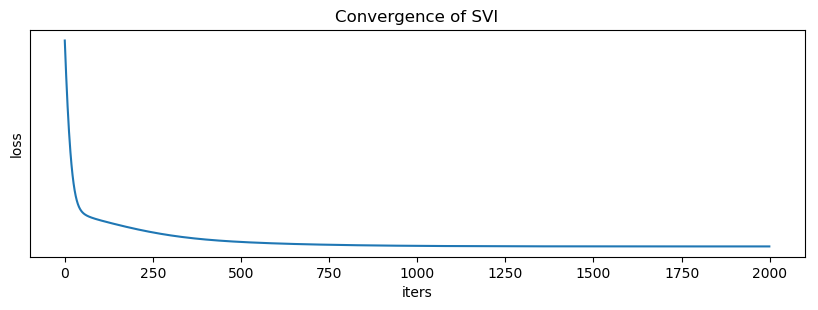

In [18]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

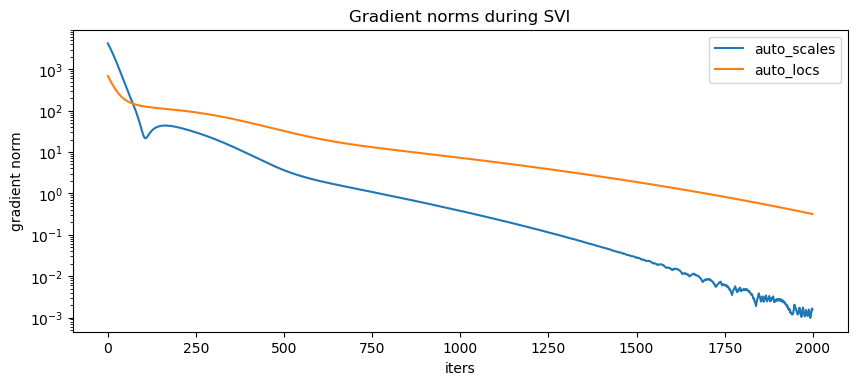

In [19]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [20]:
optim = pyro.optim.Adam({'lr': 0.005, 'betas': [0.9, 0.999]})
svi = SVI(independentGaussian, global_guide, optim, loss=elbo)

In [21]:
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

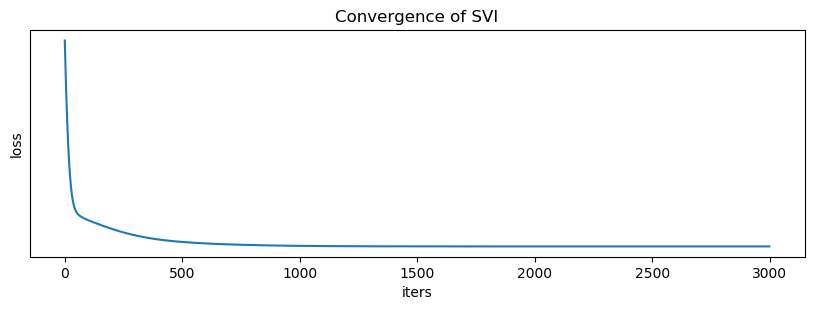

In [22]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

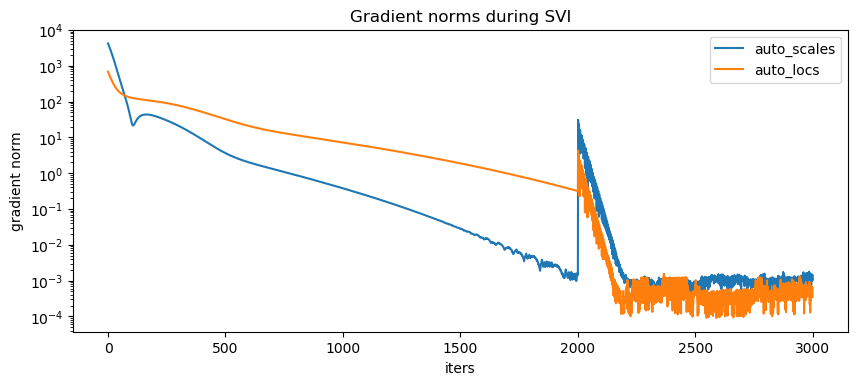

In [23]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [26]:
print(rel_err(pyro.param('auto_locs'),data.mean(0)))
print(rel_err(pyro.param('auto_scales'),np.sqrt(data.var(0))))

tensor(0.0005, grad_fn=<DivBackward0>)
tensor(0.0011, grad_fn=<DivBackward0>)
